In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Goal: To use data analytics to determine the MVP of each season of NBA basketball played since 2000.

#### We hope to remove media biases and narritives and simply present the player that statistically added the most value to their team each year.

In [12]:
player_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/player_stats/merge2000-2024.csv")
adv_player_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/advanced_stats/merge2000-2024.csv")
mvps = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/MVPs.csv")
team_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/team_stats/merge2000-2024.csv")

/var/folders/t3/tq1z8cy535bck4xjwkvc0_xh0000gn/T/ipykernel_6006/3329138357.py:2: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  adv_player_stats = pd.read_csv("/Users/sa12/Documents/Repositories/nba-stats/data/advanced_stats/merge2000-2024.csv")


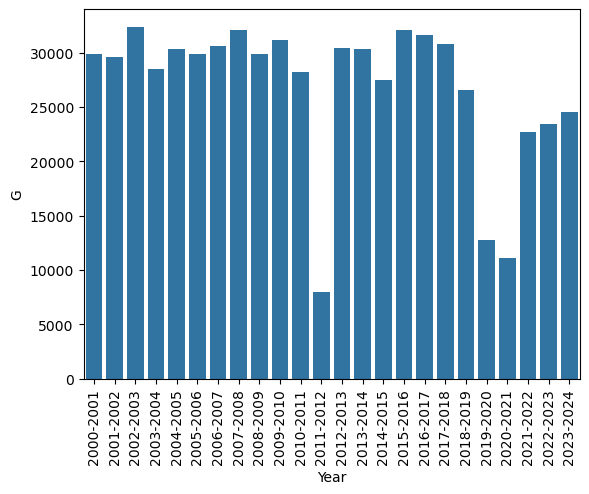

In [13]:
#In 2022, the NBA introduced a rule mandating that players play 65 games to be eligible for end of season awards.
#I am going to apply this criteria to historical data to see if it changes anything

#First line of code removes rows double-counting player's stats who were traded mid-season
player_stats = player_stats[player_stats["Team"].str.contains("2TM") == False]
eligible_players = player_stats[player_stats["G"] >= 65]
adv_player_stats = adv_player_stats[adv_player_stats["Team"].str.contains("2TM") == False]
adv_eligible_players = adv_player_stats[adv_player_stats["G"] >= 65]
games_played = eligible_players.groupby(eligible_players["Year"])["G"].sum()
sns.barplot(games_played)
plt.xticks(rotation=90)
plt.show()




We notice a sharp decline in the 2011-2012 season. Research shows this was due to only playing 66 games due to a lockout. Future analysis must account this.

We also begin to see a downward trend in 2019-2021. This is likely due to covid restrictions. However, even after restrictions were lifted, number of games played over 65 is signifcantly lower than previously.

In [14]:
#seperating combined dataframe into uniquiely defined seasons
eligible_2000_2001 = eligible_players[eligible_players["Year"] == "2000-2001"]
adv_eligible_2000_2001 = adv_eligible_players[adv_eligible_players["Year"] == "2000-2001"]
eligible_2001_2002 = eligible_players[eligible_players["Year"] == "2001-2002"]
adv_eligible_2001_2002 = adv_eligible_players[adv_eligible_players["Year"] == "2001-2002"]
eligible_2002_2003 = eligible_players[eligible_players["Year"] == "2002-2003"]
adv_eligible_2002_2003 = adv_eligible_players[adv_eligible_players["Year"] == "2002-2003"]
eligible_2003_2004 = eligible_players[eligible_players["Year"] == "2003-2004"]
adv_eligible_2003_2004 = adv_eligible_players[adv_eligible_players["Year"] == "2003-2004"]
eligible_2004_2005 = eligible_players[eligible_players["Year"] == "2004-2005"]
eligible_2005_2006 = eligible_players[eligible_players["Year"] == "2005-2006"]
eligible_2006_2007 = eligible_players[eligible_players["Year"] == "2006-2007"]
eligible_2007_2008 = eligible_players[eligible_players["Year"] == "2007-2008"]
eligible_2008_2009 = eligible_players[eligible_players["Year"] == "2008-2009"]
eligible_2009_2010 = eligible_players[eligible_players["Year"] == "2009-2010"]
eligible_2010_2011 = eligible_players[eligible_players["Year"] == "2010-2011"]
eligible_2011_2012 = eligible_players[eligible_players["Year"] == "2011-2012"]
eligible_2012_2013 = eligible_players[eligible_players["Year"] == "2012-2013"]
eligible_2013_2014 = eligible_players[eligible_players["Year"] == "2013-2014"]
eligible_2014_2015 = eligible_players[eligible_players["Year"] == "2014-2015"]
eligible_2015_2016 = eligible_players[eligible_players["Year"] == "2015-2016"]
eligible_2016_2017 = eligible_players[eligible_players["Year"] == "2016-2017"]
eligible_2017_2018 = eligible_players[eligible_players["Year"] == "2017-2018"]
eligible_2018_2019 = eligible_players[eligible_players["Year"] == "2018-2019"]
eligible_2019_2020 = eligible_players[eligible_players["Year"] == "2019-2020"]
eligible_2020_2021 = eligible_players[eligible_players["Year"] == "2020-2021"]
eligible_2021_2022 = eligible_players[eligible_players["Year"] == "2021-2022"]
eligible_2022_2023 = eligible_players[eligible_players["Year"] == "2022-2023"]
eligible_2023_2024 = eligible_players[eligible_players["Year"] == "2023-2024"]

In [15]:
adv_eligible_2003_2004

,Year,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Player-additional,Year
21852,2003-2004,Joe Johnson,22.0,PHO,SG,82.0,77.0,3331.0,13.9,0.491,...,1.1,3.3,0.047,0.1,-1.4,-1.3,0.6,NaN,johnsjo02,NaN
21853,2003-2004,Peja Stojaković,26.0,SAC,SF,81.0,81.0,3264.0,21.8,0.624,...,2.1,13.5,0.198,5.2,-1.3,3.9,4.9,MVP-4ASNBA2,stojape01,NaN
21857,2003-2004,Kevin Garnett,27.0,MIN,PF,82.0,82.0,3231.0,29.4,0.547,...,8.0,18.3,0.272,6.8,3.3,10.2,10.0,MVP-1DPOY-6ASNBA1,garneke01,NaN
21858,2003-2004,Cuttino Mobley,28.0,HOU,SG,80.0,80.0,3229.0,14.1,0.535,...,4.3,7.6,0.114,0.5,0.9,1.4,2.8,NaN,moblecu01,NaN
21859,2003-2004,Shawn Marion,25.0,PHO,SF,79.0,79.0,3217.0,19.9,0.513,...,3.8,9.1,0.135,3.0,0.6,3.6,4.6,NaN,mariosh01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102538,2003-2004,Brian Scalabrine,25.0,NJN,PF,69.0,2.0,928.0,9.5,0.482,...,1.4,1.7,0.089,-3.2,0.7,-2.6,-0.1,NaN,scalabr01,NaN
102545,2003-2004,Elden Campbell,35.0,DET,C,65.0,27.0,892.0,13.8,0.490,...,2.0,2.1,0.115,-3.0,2.0,-1.0,0.2,NaN,campbel01,NaN
102546,2003-2004,Kyle Korver,22.0,PHI,SF,74.0,0.0,882.0,10.1,0.489,...,0.8,1.0,0.054,-0.2,-0.5,-0.7,0.3,NaN,korveky01,NaN
102575,2003-2004,Shawn Bradley,31.0,DAL,C,66.0,5.0,773.0,15.6,0.523,...,0.9,2.3,0.145,-1.5,1.6,0.1,0.4,NaN,bradlsh01,NaN


In [16]:
raw_value_2000_2001 = pd.DataFrame(eligible_2000_2001["Player"])
#dataframe of eligible players in the season
#create an aggregate number based on the sum of traditional counting stats subtracted by the sum of traditional negative stats
raw_value_2000_2001["Raw Score"] = eligible_2000_2001["PTS"] + eligible_2000_2001["AST"] + eligible_2000_2001["TRB"] + eligible_2000_2001["BLK"] + eligible_2000_2001["STL"] - eligible_2000_2001["PF"] - eligible_2000_2001["TOV"]
#Raw Value = Points + Assists + Rebounds + Blocks + Steals - Fouls - Turnovers
raw_value_2000_2001["eFG%"] = eligible_2000_2001["eFG%"]
#Added a column with Effective Field Goal % to give an idea of effiency in scoring points, the largest portion of our raw score.
raw_value_2000_2001 = raw_value_2000_2001.set_index("Player")
#Setting the index to lock players to the values, than sorting in decending order
raw_value_2000_2001 = raw_value_2000_2001.sort_values("Raw Score", ascending=False)
#Now we can view our top 10 players in "Raw Value"
raw_value_2000_2001.head(10)

,Raw Score,eFG%
Player,,
Shaquille O'Neal,3119.0,0.572
Shaquille O'Neal,3119.0,0.572
Kevin Garnett,2928.0,0.484
Kevin Garnett,2928.0,0.484
Tracy McGrady,2873.0,0.474
Tracy McGrady,2873.0,0.474
Tim Duncan,2835.0,0.502
Tim Duncan,2835.0,0.502
Jerry Stackhouse,2770.0,0.445


WOAH. The first year tested showed something interesting. The MVP for the 2000-2001 season was Allen Iverson. Based on the aggregate of pure counting stats however, Allen Iverson is 9th highest Value Score. His effciency does not seem remarkable either. Lets see if the advanced stats back this up

In [17]:
adv_eligible_2000_2001.head(10)

,Year,Player,Age,Team,Pos,G,GS,MP,PER,TS%,...,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Awards,Player-additional,Year


In [18]:
eligible_2011_2012



,Year,Player,Age,Team,Pos,G,GS,MP,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,PTS,Trp-Dbl,Awards,Player-additional
0,2011-2012,Kevin Durant,23.0,OKC,SF,66.0,66.0,2546.0,643.0,1297.0,...,527.0,231.0,88.0,77.0,248.0,133.0,1850.0,0.0,MVP-2ASNBA1,duranke01
3,2011-2012,Russell Westbrook,23.0,OKC,PG,66.0,66.0,2331.0,578.0,1266.0,...,301.0,362.0,112.0,21.0,239.0,147.0,1558.0,0.0,MVP-12DPOY-18ASNBA2,westbru01
5,2011-2012,Blake Griffin,22.0,LAC,PF,66.0,66.0,2392.0,561.0,1022.0,...,717.0,210.0,54.0,48.0,150.0,216.0,1368.0,0.0,ASNBA2,griffbl01
7,2011-2012,Brandon Jennings,22.0,MIL,PG,66.0,66.0,2331.0,469.0,1121.0,...,226.0,365.0,104.0,22.0,146.0,114.0,1260.0,0.0,NaN,jennibr01
9,2011-2012,Josh Smith,26.0,ATL,PF,66.0,66.0,2329.0,504.0,1101.0,...,632.0,257.0,93.0,115.0,164.0,172.0,1239.0,0.0,DPOY-10,smithjo03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4700,2011-2012,Kendrick Perkins,27.0,OKC,C,65.0,65.0,1744.0,128.0,262.0,...,426.0,78.0,25.0,73.0,118.0,189.0,329.0,0.0,NaN,perkike01
4709,2011-2012,Shane Battier,33.0,MIA,SF,65.0,10.0,1499.0,113.0,292.0,...,156.0,82.0,64.0,33.0,37.0,105.0,311.0,0.0,NaN,battish01
4712,2011-2012,Chris Singleton,22.0,WAS,SF,66.0,51.0,1431.0,116.0,312.0,...,233.0,49.0,70.0,30.0,38.0,176.0,306.0,0.0,NaN,singlch01
4713,2011-2012,Enes Freedom,19.0,UTA,C,66.0,0.0,874.0,117.0,236.0,...,278.0,8.0,18.0,23.0,54.0,87.0,304.0,0.0,NaN,kanteen01


In [19]:
print(mvps)

       Year                 Player Voting  Age   Tm   G    MP   PTS   TRB  \
0   2023-24           Nikola Jokić    (V)   28  DEN  79  34.6  26.4  12.4   
1   2022-23            Joel Embiid    (V)   28  PHI  66  34.6  33.1  10.2   
2   2021-22           Nikola Jokić    (V)   26  DEN  74  33.5  27.1  13.8   
3   2020-21           Nikola Jokić    (V)   25  DEN  72  34.6  26.4  10.8   
4   2019-20  Giannis Antetokounmpo    (V)   25  MIL  63  30.4  29.5  13.6   
5   2018-19  Giannis Antetokounmpo    (V)   24  MIL  72  32.8  27.7  12.5   
6   2017-18           James Harden    (V)   28  HOU  72  35.4  30.4   5.4   
7   2016-17      Russell Westbrook    (V)   28  OKC  81  34.6  31.6  10.7   
8   2015-16          Stephen Curry    (V)   27  GSW  79  34.2  30.1   5.4   
9   2014-15          Stephen Curry    (V)   26  GSW  80  32.7  23.8   4.3   
10  2013-14           Kevin Durant    (V)   25  OKC  81  38.5  32.0   7.4   
11  2012-13           LeBron James    (V)   28  MIA  76  37.9  26.8   8.0   